In [45]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy
from sklearn.metrics import mean_squared_error

import ase.io


# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion

from rascalLodeCombinator import rascalLodeCombinator

In [46]:
def rmse(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [47]:
refFrame = ase.io.read("exfoliation_mbd_reference.xyz", "99:")
train_frames = ase.io.read("exfoliation_mbd_reference.xyz", ":40")
train_frames += refFrame
test_frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")

train_energy = np.array([
    frame.info["energy"] for frame in train_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in train_frames
])

test_energy = np.array([
    frame.info["energy"] for frame in test_frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in test_frames
])

In [48]:
hypers_lr = {
    'smearing':0.7,
    'max_angular':0,
    'max_radial':10,
    'cutoff_radius':5.,
    'potential_exponent':6,
    'radial_basis': 'gto',
    'compute_gradients':True
}

hypers_rascaline = {
    "cutoff": 4.5,
    "atomic_gaussian_width": 0.7,
    "max_radial": 6,
    "max_angular": 6,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 1.}},
    "gradients": True
}

In [49]:
### the lode model in this notebook is a v=1 model with lmax = 0 and nmax = 10

In [50]:
calculator_lode = PyLODESphericalExpansion(hypers_lr)
calculator_rascaline = RascalineSphericalExpansion(hypers_rascaline)

train_lode = calculator_lode.compute(train_frames)
train_rascaline = calculator_rascaline.compute(train_frames)

test_lode = calculator_lode.compute(test_frames)
test_rascaline = calculator_rascaline.compute(test_frames)

ps_train_rascaline = compute_power_spectrum(train_rascaline)
ps_test_rascaline = compute_power_spectrum(test_rascaline)

In [51]:
train_lode.components_to_properties(['spherical_harmonics_m'])
train_lode.keys_to_properties(['neighbor_species','spherical_harmonics_l'])
train_lode.keys_to_samples('center_species')
test_lode.components_to_properties(['spherical_harmonics_m'])
test_lode.keys_to_properties(['neighbor_species','spherical_harmonics_l'])
test_lode.keys_to_samples('center_species')

In [52]:
ps_train_rascaline.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
ps_train_rascaline.keys_to_samples('center_species')
ps_test_rascaline.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
ps_test_rascaline.keys_to_samples('center_species')

In [53]:
alpha = 1e-1
train_merged = rascalLodeCombinator(train_lode, ps_train_rascaline,alpha=alpha)
test_merged = rascalLodeCombinator(test_lode, ps_test_rascaline,alpha=alpha)

In [54]:
### Linear model
model = LinearModel(do_normalize=False, regularizer=[1.25e-4, 1.25e-4])
model.fit(train_merged, train_energy, train_forces)
pred_energy, pred_forces = model.predict(test_merged, with_forces=True)

In [55]:
### Sparse Lineaer model
# model = LinearModel(normalize=True, regularizer=[1.25e-4, 0.5e-4])
# sparse_points = select_support_points(train_merged, n_select=40)
# model.fit(sparse_points, train_energy, train_forces)
# pred_energy, pred_forces = model.predict(test_merged, with_forces=True)

In [56]:
### Sparse kernels model
# support = select_support_points(train_merged, n_select=40)
# model = SparseKernelGap(support_points=support, zeta=1, regularizer=[1e-4, 1e-4])
# model.fit(train_merged, train_energy, train_forces)
# pred_energy, pred_forces = model.predict(test_merged, with_forces=True)

In [57]:
test_energy_per_atom=[]
pred_energy_per_atom=[]

for i in np.arange(len(test_frames)):
    n_atoms = len(test_frames[i])
    test_energy_per_atom.append(test_energy[i]/n_atoms)
    pred_energy_per_atom.append(pred_energy[i]/n_atoms)

test_energy_per_atom=np.array(test_energy_per_atom)
pred_energy_per_atom=np.array(pred_energy_per_atom)

print('Energy RMSE (eV/atom) of the rascaline+pyLODE model is:')
print(rmse(test_energy_per_atom, pred_energy_per_atom))
print('Forces RMSE (eV/A) of the rascaline+pyLODE model is:')
print(rmse(test_forces.flatten(), pred_forces.flatten()))

Energy RMSE (eV/atom) of the rascaline+pyLODE model is:
[0.00143552]
Forces RMSE (eV/A) of the rascaline+pyLODE model is:
0.004444833876084638


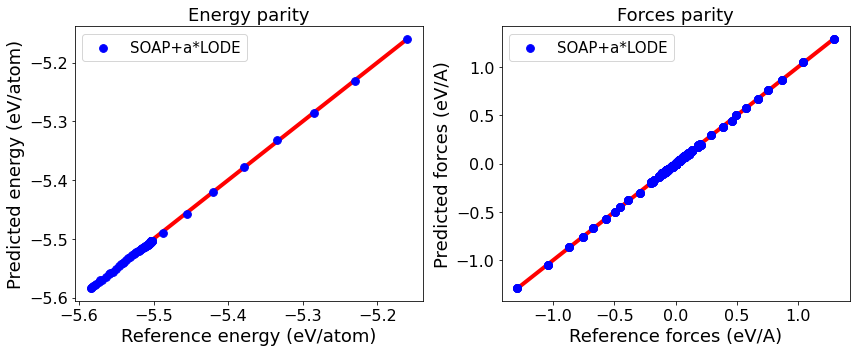

In [58]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
x = [test_energy_per_atom.min(), test_energy_per_atom.max()]
ax[0].set_title('Energy parity',fontsize=18)
ax[0].set_xlabel('Reference energy (eV/atom)',fontsize=18)
ax[0].set_ylabel('Predicted energy (eV/atom)',fontsize=18)
ax[0].tick_params(labelsize=16)
ax[0].plot(x, x, color="r",linewidth=4)
ax[0].scatter(test_energy_per_atom, pred_energy_per_atom,color='blue',label='SOAP+a*LODE',zorder=3,s=60)
ax[0].legend(markerscale=1,fontsize=15)

xx = [test_forces.flatten().min(), test_forces.flatten().max()]
ax[1].set_title('Forces parity',fontsize=18)
ax[1].set_xlabel('Reference forces (eV/A)',fontsize=18)
ax[1].set_ylabel('Predicted forces (eV/A)',fontsize=18)
ax[1].tick_params(labelsize=16)
ax[1].plot(xx, xx, color="r",linewidth=4)
ax[1].scatter(test_forces.flatten(), pred_forces.flatten(),color='blue',label='SOAP+a*LODE',zorder=3,s=60)
ax[1].legend(markerscale=1,fontsize=15)

plt.tight_layout()

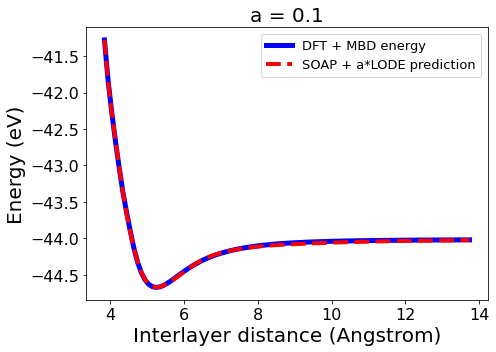

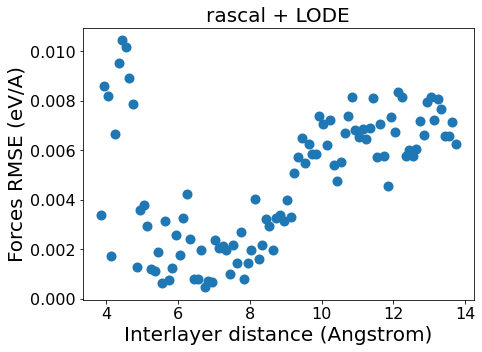

In [61]:
dist_list = []
error_forces = []

for i in np.arange(len(test_frames)):
    dist = test_frames[i].get_positions()[0,1]-test_frames[i].get_positions()[6,1]
    dist_list.append(dist)
    error = np.sqrt(np.sum(
        np.power( pred_forces[8*i:8*(i+1),1:3]-test_forces[8*i:8*(i+1),1:3],2)
    )/16)
    error_forces.append(error)

fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('Energy (eV)',fontsize=20)
ax.tick_params(labelsize=16)
ax.set_title('a = '+str(alpha),fontsize=20)

ax.plot(dist_list, test_energy,'-',label='DFT + MBD energy ',linewidth=5,color='blue')
ax.plot(dist_list, pred_energy,'--',label='SOAP + a*LODE prediction',linewidth=4,color='red')

ax.legend(markerscale=2,fontsize=13)

plt.tight_layout()


fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('Forces RMSE (eV/A)',fontsize=20)
ax.scatter(dist_list, error_forces,linewidth=4)
ax.set_title('rascal + LODE',fontsize=20)
ax.tick_params(labelsize=16)